In [1]:
import pickle

import torch
import matplotlib.pyplot as plt

from dataset import get_dataset
from model import Model as Base

In [2]:
EXP_DIR = 'results/smoothing/2024-06-27-16-41-29'
CKPT = 300
SPLIT = 'val'

with open(f'{EXP_DIR}/config.pkl', 'rb') as f:
    config = pickle.load(f)

DEVICE = torch.device(f'cuda:{config.device_index}' if torch.cuda.is_available() and config.device_index is not None else 'cpu')
dataset = get_dataset(config.dataset, config.task, DEVICE)

In [3]:
class Model(Base):

    def forward(self, x, edge_index, mask):

        for mp_layer in self.message_passing:
            x = mp_layer(x, edge_index)
            yield x

        out = self.readout(x, mask)
        yield out

model = Model(config).to(device=DEVICE)
state_dict = torch.load(f'{EXP_DIR}/ckpt-{CKPT}.pt')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [4]:
model.eval()

with torch.no_grad():
    *representations, logits = model(dataset.x, dataset.edge_index, mask=dataset.test_mask)

dataset.compute_loss(logits, dataset.y[dataset.test_mask])
dataset.compute_metrics()

[('Cross Entropy Loss', 0.5278717041015625),
 ('Accuracy', 0.8379963040351868),
 ('F1 Score', 0.8460693359375),
 ('AU-ROC', 0.9691168665885925)]

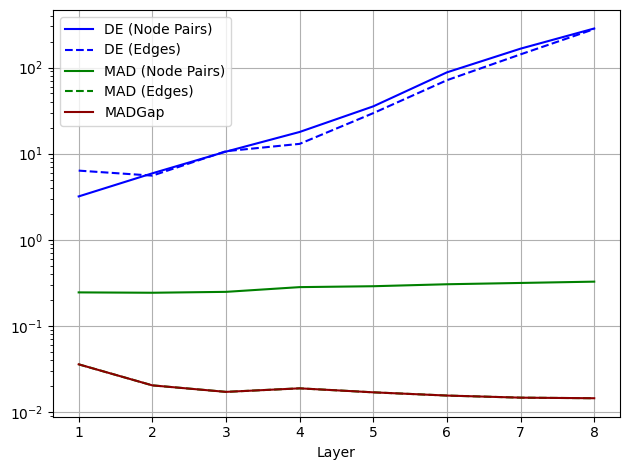

In [5]:
dir_energies_all, dir_energies_edges, mad_vals_all, mad_vals_edges, mad_gaps = list(), list(), list(), list(), list()

for representation in representations:

    pairwise_euclidean_sq = torch.square(torch.cdist(representation, representation))
    dir_energy_all = torch.mean(pairwise_euclidean_sq).item()
    dir_energies_all.append(dir_energy_all)
    dir_energy_edges = torch.mean(pairwise_euclidean_sq[dataset.edge_index[0], dataset.edge_index[1]]).item(); 
    dir_energies_edges.append(dir_energy_edges)
    
    pairwise_cossim = torch.nn.CosineSimilarity(dim=-1, eps=1e-20)(representation.unsqueeze(0), representation.unsqueeze(1))
    mad_val_all = 1 - torch.mean(pairwise_cossim).item()
    mad_vals_all.append(mad_val_all)
    mad_val_edges = 1 - torch.mean(pairwise_cossim[dataset.edge_index[0], dataset.edge_index[1]]).item()
    mad_vals_edges.append(mad_val_edges)
    mask_nbr = torch.zeros_like(pairwise_cossim)
    mask_nbr[dataset.edge_index[0], dataset.edge_index[1]] = 1.
    mad_nbr = 1 - torch.mean(torch.sum(pairwise_cossim*mask_nbr, dim=1) / torch.sum(mask_nbr, dim=1)).item()
    mask_rmt = torch.ones_like(pairwise_cossim)
    mask_rmt[dataset.edge_index[0], dataset.edge_index[1]] = 0.
    mad_rmt = 1 - torch.mean(torch.sum(pairwise_cossim*mask_rmt, dim=1) / torch.sum(mask_rmt, dim=1)).item()
    mad_gaps.append(mad_rmt-mad_nbr)

plt.plot(range(1, len(dir_energies_all)+1), dir_energies_all, 'b-', label='DE (Node Pairs)')
plt.plot(range(1, len(dir_energies_edges)+1), dir_energies_edges, 'b--', label='DE (Edges)')
plt.plot(range(1, len(mad_vals_all)+1), mad_vals_all, 'g-', label='MAD (Node Pairs)')
plt.plot(range(1, len(mad_vals_edges)+1), mad_vals_edges, 'g--', label='MAD (Edges)')
plt.plot(range(1, len(mad_vals_edges)+1), mad_vals_edges, 'darkred', label='MADGap')
plt.xlabel('Layer')
plt.yscale('log')
plt.legend()
plt.grid(which='major')
plt.tight_layout()
plt.show()

# cross-checked with the results using the official implementation
# https://github.com/victorchen96/MadGap/blob/4e49f254bde40b181e749a51dbc7a3abc3153d4c/madgap.py#L13